In [2]:
from arcos4py.tools import track_events_image, remove_image_background
from arcos4py.tools._detect_events import upscale_image
from arcos4py.tools._cleandata import blockwise_median
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from napari.viewer import Viewer
from skimage import io
import napari
from scipy.ndimage import distance_transform_edt

In [3]:
import numpy as np
from scipy.ndimage import binary_dilation, binary_fill_holes, binary_erosion
from skimage.morphology import erosion, remove_small_objects, square
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from skimage import io
import numpy as np
from skimage import io, exposure

import numpy as np
from scipy import ndimage
from skimage.morphology import closing

import numpy as np
from statsmodels.nonparametric.smoothers_lowess import lowess

import numpy as np
from scipy.signal import savgol_filter


def drop_scattered_small_labels(label_image, min_size=100):
    """
    Removes small scattered regions of each label from a labeled image.

    Parameters:
    - label_image: 2D numpy array representing the labeled image.
    - min_size: Minimum pixel size for keeping a scattered part of a label.

    Returns:
    - Processed image with small scattered labels dropped.
    """
    label_image = closing(label_image)
    unique_labels = np.unique(label_image)
    output_image = np.zeros_like(label_image)

    for label in unique_labels:
        if label == 0:  # Assuming 0 is the background
            continue

        # Create a binary image for the current label
        binary_mask = label_image == label

        # Identify separate regions of the current label
        labeled_mask, num_features = ndimage.label(binary_mask)

        # Measure the size of each region
        sizes = ndimage.sum(binary_mask, labeled_mask, range(num_features + 1))

        # Create a mask of regions to be kept for the current label
        mask_size = sizes >= min_size
        keep = mask_size[labeled_mask]

        # Update the output image with regions of the current label that are kept
        output_image[keep] = label

    return output_image


def process_time_series_label_images(time_series_label_images, min_size=100):
    """
    Processes a time-series of label images by removing small scattered labels.

    Parameters:
    - time_series_label_images: 3D numpy array representing a time-series of labeled images.
      The first dimension is time.
    - min_size: Minimum pixel size for keeping a scattered part of a label.

    Returns:
    - Processed time-series with small scattered labels dropped from each frame.
    """

    # Get the number of time points
    T = time_series_label_images.shape[0]

    # Initialize an output array of the same shape as the input
    output_images = np.zeros_like(time_series_label_images)

    for t in range(T):
        output_images[t] = drop_scattered_small_labels(time_series_label_images[t], min_size=min_size)

    return output_images


def filter_by_centroid_displacement(labeled_stack, min_distance):
    """
    Removes tracks from a labeled image stack if the total displacement of their centroid
    is less than the specified minimum distance.
    """
    labeled_stack = np.copy(labeled_stack)

    unique_labels = np.unique(labeled_stack)[1:]  # Exclude background (label 0)

    for label in unique_labels:
        # Get the coordinates of all pixels belonging to the current label (track) for each time point
        time_points = np.unique(np.where(labeled_stack == label)[0])

        centroids = []
        for t in time_points:
            coords = np.argwhere(labeled_stack[t] == label)
            centroid = coords.mean(axis=0)
            centroids.append(centroid)

        # Calculate the total centroid displacement by summing up the distances between consecutive time points
        total_distance = sum(np.linalg.norm(centroids[i + 1] - centroids[i]) for i in range(len(centroids) - 1))

        # If total displacement is less than min_distance, remove the track
        if total_distance < min_distance:
            labeled_stack[labeled_stack == label] = 0

    return labeled_stack


def filter_by_duration(labeled_stack, min_duration):
    """
    Removes tracks from a labeled image stack if their duration is less than the specified minimum.
    """
    labeled_stack = np.copy(labeled_stack)

    unique_labels = np.unique(labeled_stack)[1:]  # Exclude background (label 0)

    for label in unique_labels:
        # Get the coordinates of all pixels belonging to the current label (track) for each time point
        time_points = np.unique(np.where(labeled_stack == label)[0])

        # If the duration is less than min_duration, remove the track
        if len(time_points) < min_duration:
            labeled_stack[labeled_stack == label] = 0

    return labeled_stack


def smooth_segmentation(binary_objects, expand_iterations=1, remove_small=True, remove_small_objects_size=100):
    """
    Smooths the segmentation by removing small objects and filling holes.

    Parameters
    ----------
    binary_objects : numpy array
        Binary image of the segmented objects.
    remove_small : bool, optional
        Whether to remove small objects. The default is True.
    remove_small_objects_size : int, optional
        Size of the objects to remove. The default is 100.

    Returns
    -------
    binary_objects : numpy array
        Smoothed binary image of the segmented objects.
    """
    binary_objects = np.where(binary_objects == 2, 1, 0)
    if len(binary_objects.shape) == 3:
        for index, image in enumerate(binary_objects):
            image = binary_fill_holes(image)
            image = binary_dilation(image, square(5), iterations=expand_iterations)
            image = erosion(image, footprint=square(5))
            bool_img = image.astype(bool)
            if remove_small:
                image = remove_small_objects(bool_img, min_size=remove_small_objects_size**2)
            image = binary_fill_holes(image)
            binary = np.where(image, 1, 0)
            binary_objects[index] = binary
        return binary_objects
    else:
        binary_objects = binary_fill_holes(binary_objects)
        binary_objects = binary_dilation(binary_objects, square(5), iterations=expand_iterations)
        binary_objects = erosion(binary_objects, footprint=square(5))
        bool_img = binary_objects.astype(bool)
        if remove_small:
            binary_objects = remove_small_objects(bool_img, min_size=remove_small_objects_size**2)
        binary_objects = binary_fill_holes(binary_objects)
        binary_objects = np.where(binary_objects, 1, 0)
        return binary_objects

def bleach_correction_smooth(img_stack, window_length=11, polyorder=2):
    """
    Perform bleach correction on a t,y,x image stack using Savitzky-Golay smoothing.

    Parameters:
    - img_stack: 3D numpy array with shape (t, y, x)
    - window_length: Length of the filter window (must be odd).
    - polyorder: Order of the polynomial used to fit the samples.

    Returns:
    - Corrected 3D numpy array with same shape as img_stack
    """

    # Convert img_stack to float type for the correction
    img_stack = img_stack.astype(np.float64)

    # Calculate average intensity for each time point
    avg_intensities = img_stack.mean(axis=(1, 2))

    # Apply Savitzky-Golay filter to average intensities
    smoothed_intensities = savgol_filter(avg_intensities, window_length, polyorder)

    # Calculate correction factors
    correction_factors = smoothed_intensities / avg_intensities[0]

    # Apply correction to the image stack
    for i in range(img_stack.shape[0]):
        img_stack[i] /= correction_factors[i]

    return img_stack


def bleach_correction_loess(img_stack, frac=0.1):
    """
    Perform bleach correction on a t,y,x image stack using LOESS smoothing.

    Parameters:
    - img_stack: 3D numpy array with shape (t, y, x)
    - frac: The fraction of data used when estimating each y-value for the lowess fit.
            It determines the span of the window; for example, a value of 0.1 means
            each smoothed point uses 10% of the data points.

    Returns:
    - Corrected 3D numpy array with same shape as img_stack
    """

    # Convert img_stack to float type for the correction
    img_stack = img_stack.astype(np.float64)

    # Calculate average intensity for each time point
    avg_intensities = img_stack.mean(axis=(1, 2))

    # Time points
    t_values = np.arange(len(avg_intensities))

    # Apply LOESS smoothing to average intensities
    smoothed_intensities = lowess(avg_intensities, t_values, frac=frac, return_sorted=False)

    # Calculate correction factors
    correction_factors = smoothed_intensities / avg_intensities[0]

    # Apply correction to the image stack
    for i in range(img_stack.shape[0]):
        img_stack[i] /= correction_factors[i]

    return img_stack


def match_histogram(source, template):
    hist_source, bin_edges = np.histogram(source.ravel(), bins=65536, range=(0, 65536))
    hist_template, _ = np.histogram(template.ravel(), bins=65536, range=(0, 65536))

    cdf_source = hist_source.cumsum() / hist_source.sum()
    cdf_template = hist_template.cumsum() / hist_template.sum()

    lookup_table = np.zeros(65536, dtype=np.uint16)
    j = 0
    for i in range(65536):
        while cdf_template[j] < cdf_source[i] and j < 65535:
            j += 1
        lookup_table[i] = j

    matched = lookup_table[source]
    return matched


def match_histogram_stack(img_stack, template):
    matched_stack = np.zeros_like(img_stack)
    for i in range(img_stack.shape[0]):
        matched_stack[i] = match_histogram(img_stack[i], template)
    return matched_stack

In [4]:
unstable_fibres = io.imread("transfer_187559_files_94515bab/lifeact_myosin_rgbd7_w15TIRF-GFP_s1_t1.TIF_-_Stage1__Position_11_.tiff")
stable_fibres = io.imread("transfer_187559_files_94515bab/lifeact_myosin_rgbd7_w15TIRF-GFP_s1_t1.TIF_-_Stage2__Position_12_.tiff")

In [5]:
import napari
viewer = napari.Viewer()
viewer.add_image(unstable_fibres, name="unstable fibres")
viewer.add_image(stable_fibres, name="stable fibres")

<Image layer 'stable fibres' at 0x7f886be40bb0>

In [6]:
from tqdm.auto import tqdm

myosin_bl = []
rGBD_bl = []
actin_bl = []

myosin = stable_fibres[..., 1]
rGBD = stable_fibres[..., 2]
actin = stable_fibres[..., 0]
reference_myosin = myosin[0]
reference_rGBD = rGBD[0]
reference_actin = actin[0]
myosin_bl.append(np.stack([match_histogram(img, reference_myosin) for img in tqdm(myosin)]))
rGBD_bl.append(np.stack([match_histogram(img, reference_rGBD) for img in tqdm(rGBD)]))
actin_bl.append(np.stack([match_histogram(img, reference_actin) for img in tqdm(actin)]))
myosin_bl = np.concatenate(myosin_bl)
rGBD_bl = np.concatenate(rGBD_bl)
actin_bl = np.concatenate(actin_bl)

  0%|          | 0/721 [00:00<?, ?it/s]

  0%|          | 0/721 [00:00<?, ?it/s]

  0%|          | 0/721 [00:00<?, ?it/s]

In [7]:
viewer = napari.Viewer()
# viewer.add_image(actin)
viewer.add_image(actin_bl)


<Image layer 'actin_bl' at 0x7f8889adb820>

In [8]:
binned_actin = blockwise_median(actin, (1, 3, 3))
binned_actin.shape
# io.imsave("binned_actin.tif", binned_actin)

(721, 180, 180)

In [9]:
viewer = napari.Viewer()
viewer.add_image(binned_actin)
viewer.add_image(actin_bl)

<Image layer 'actin_bl' at 0x7f886c227250>

In [10]:
from skimage.morphology import opening
from skimage.filters import gaussian

In [11]:
actin_bg = remove_image_background(binned_actin, size=(100, 1, 1), filter_type="median", crop_time_axis=True)
actin_bg = np.where(actin_bg < 0, 0, actin_bg)

(array([1.8175637e+07, 8.6540400e+05, 3.2621700e+05, 1.9172100e+05,
        1.1522000e+05, 8.8172000e+04, 6.2133000e+04, 5.2264000e+04,
        4.2114000e+04, 3.1614000e+04, 2.8311000e+04, 2.1678000e+04,
        1.9491000e+04, 1.5283000e+04, 1.3247000e+04, 1.1220000e+04,
        8.7860000e+03, 7.7750000e+03, 6.0600000e+03, 5.6020000e+03,
        4.3650000e+03, 4.0620000e+03, 3.4290000e+03, 2.6800000e+03,
        2.4730000e+03, 1.9430000e+03, 1.8540000e+03, 1.3460000e+03,
        1.3260000e+03, 1.0970000e+03, 9.2700000e+02, 8.2500000e+02,
        7.0400000e+02, 6.7400000e+02, 5.2000000e+02, 4.8500000e+02,
        4.0700000e+02, 3.5300000e+02, 3.4300000e+02, 2.9600000e+02,
        2.6500000e+02, 2.1500000e+02, 2.0800000e+02, 1.9500000e+02,
        1.6000000e+02, 1.4800000e+02, 1.2200000e+02, 1.1600000e+02,
        7.8000000e+01, 1.0600000e+02, 7.2000000e+01, 7.6000000e+01,
        6.6000000e+01, 5.0000000e+01, 5.0000000e+01, 3.5000000e+01,
        3.6000000e+01, 4.2000000e+01, 3.1000000e

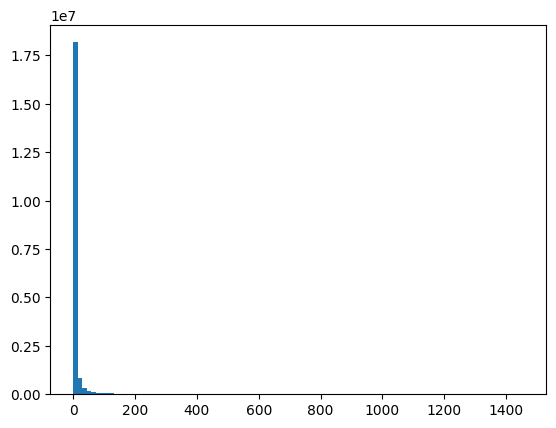

In [12]:
plt.hist(actin_bg.ravel(), bins=100)

In [13]:
viewer = napari.Viewer()
#viewer.add_image(actin_bg_bl)
viewer.add_image(actin_bg)
# viewer.add_labels(track_events_image(actin_bg > 3, eps=5, minClSz=15, predictor=True, nPrev=3))

<Image layer 'actin_bg' at 0x7f8778f3a850>

In [14]:
test = gaussian(actin_bg, sigma=1)

In [15]:
viewer = napari.Viewer()
viewer.add_image(test)
viewer.add_image(actin_bg)
viewer.add_image(binned_actin)

<Image layer 'binned_actin' at 0x7f886caf6eb0>

# Do seg with convpaint

In [16]:
viewer = napari.Viewer()
viewer.add_image(binned_actin)
# viewer.add_labels(events_1)

<Image layer 'binned_actin' at 0x7f877907d460>

In [17]:
# viewer = napari.Viewer()
viewer = napari.Viewer()
viewer.add_image(test)
# viewer.add_image(binned_actin[50:-50])
# viewer.add_labels(events_1)

<Image layer 'test' at 0x7f877a322910>

In [18]:
from cellpose import models

In [19]:
model = models.Cellpose(gpu=True, model_type="cyto2")

In [20]:
seg_cp = np.zeros_like(binned_actin)

In [21]:
for idx, img in enumerate(binned_actin):
    masks, flows, styles, diams = model.eval(img, diameter=60, channels=[0, 0], do_3D=False, net_avg=True)
    seg_cp[idx] = masks




In [22]:
seg_cp.astype(np.uint8).shape

(721, 180, 180)

In [23]:
viewer.add_labels(seg_cp.astype(np.uint8))

<Labels layer 'Labels' at 0x7f877be52850>

In [24]:
dist_transform = []
for i in seg_cp:
    dist_transform.append(distance_transform_edt(i).astype(np.uint16))

dist_transform = np.stack(dist_transform)
viewer = napari.Viewer()
viewer.add_image(dist_transform)

<Image layer 'dist_transform' at 0x7f87884ceee0>

In [25]:
dist_transform_upscaled = []
for t in dist_transform:
    t_img = upscale_image(t, 3)
    dist_transform_upscaled.append(t_img)

dist_transform_upscaled = np.stack(dist_transform_upscaled)
viewer = napari.Viewer()
viewer.add_image(dist_transform_upscaled)

<Image layer 'dist_transform_upscaled' at 0x7f87888bb1c0>

In [26]:
test_no_edge = np.where((dist_transform[50:-50] < 5), 0, test)

In [27]:
viewer.add_image(test_no_edge, name="test_no_edge")

<Image layer 'test_no_edge' at 0x7f878362b3d0>

In [28]:
events_1 = track_events_image(test_no_edge > 40, eps=3, epsPrev=3, minClSz=8, predictor=True, nPrev=3, downsample=1)

100%|██████████| 621/621 [00:04<00:00, 135.25it/s]


In [29]:
viewer.add_labels(events_1, name="events_1")

<Labels layer 'events_1' at 0x7f878362b8b0>

In [30]:
events_1_filtered = process_time_series_label_images(events_1, 5)
events_1_filtered = filter_by_duration(events_1_filtered, 10)

In [31]:
viewer = napari.current_viewer()
viewer.add_labels(events_1, name="events_1")
# viewer.add_labels(events_1_filtered, name="events_1_filtered")

<Labels layer 'events_1' at 0x7f87190e6e80>

In [32]:
events_upscaled = []
for t in events_1_filtered:
    t_img = upscale_image(t, 3)
    events_upscaled.append(t_img)

events_upscaled = np.stack(events_upscaled)

In [33]:
viewer = napari.current_viewer()
viewer.add_labels(events_upscaled, name="events_1")

<Labels layer 'events_1 [1]' at 0x7f86a01524c0>

In [34]:
viewer = napari.Viewer()
viewer.add_image(stable_fibres[50:-50, ...,0 ], name="binned_actin")
viewer.add_labels(events_upscaled, name="events_1")

<Labels layer 'events_1' at 0x7f86a8010100>

In [35]:
unstable_fibres.shape

(721, 540, 540, 3)

In [36]:
actin[0].shape

(540, 540)

In [37]:
from skimage.measure import regionprops_table

df_all = []
for idx, e in enumerate(events_upscaled):
    props = regionprops_table(e, properties=("label", "area", "centroid", 'intensity_mean'), intensity_image=actin[idx][:, :1160])
    df_temp = pd.DataFrame(props)
    df_temp["frame"] = idx
    df_all.append(df_temp)

df_all = pd.concat(df_all)

df_all.rename(columns={"centroid-0": "x", "centroid-1": "y", "label": "id"}, inplace=True)

In [38]:
df_all

,id,area,x,y,intensity_mean,frame
0,1,3321.0,68.065041,416.211382,230.627823,0
1,2,279.0,38.161290,346.967742,248.372760,0
2,3,90.0,45.700000,230.800000,288.077778,0
3,4,612.0,149.455882,129.029412,123.642157,0
4,5,513.0,167.789474,45.105263,212.430799,0
...,...,...,...,...,...,...
6,249,189.0,152.714286,401.285714,246.587302,620
7,258,1035.0,149.956522,133.104348,196.256039,620
8,260,180.0,353.500000,466.750000,247.038889,620
9,264,261.0,10.103448,447.379310,252.509579,620


In [39]:
selected_data = df_all.iloc[:12, [2, 3]]
selected_data


,x,y
0,68.065041,416.211382
1,38.161290,346.967742
2,45.700000,230.800000
3,149.455882,129.029412
4,167.789474,45.105263
5,204.830189,187.679245
6,199.000000,41.500000
7,207.375000,76.750000
8,236.592784,147.319588
9,344.740741,298.185185


In [40]:
viewer = napari.Viewer()
viewer.add_image(stable_fibres[50:-50, ...,0 ], name="binned_actin")
viewer.add_labels(events_upscaled, name="events_1")
point_layer = viewer.add_points(selected_data, size=5, symbol='cross', name='cross_points')


In [41]:
events_upscaled.shape

(621, 540, 540)

In [42]:
import pandas as pd
import numpy as np


def get_summary_statistics(df):
    # Initializing lists to hold statistics for all objects
    obj_ids = []
    origin_x = []
    origin_y = []
    origin_t = []
    end_x = []
    end_y = []
    end_t = []
    lifetimes = []
    avg_sizes = []
    avg_velocities = []
    persistences = []

    for obj_id in df["id"].unique():
        obj_df = df[df["id"] == obj_id].sort_values(by="frame")

        # Origin and End points
        origin_x.append(obj_df.iloc[0]["x"])
        origin_y.append(obj_df.iloc[0]["y"])
        origin_t.append(obj_df.iloc[0]["frame"])
        end_x.append(obj_df.iloc[-1]["x"])
        end_y.append(obj_df.iloc[-1]["y"])
        end_t.append(obj_df.iloc[-1]["frame"])

        # Lifetime
        lifetime = obj_df["frame"].max() - obj_df["frame"].min() + 1
        lifetimes.append(lifetime)

        # Average size
        avg_sizes.append(obj_df["area"].mean())

        # Average velocity
        obj_df["dx"] = obj_df["x"].diff()
        obj_df["dy"] = obj_df["y"].diff()
        obj_df["dt"] = obj_df["frame"].diff()
        velocities = np.sqrt(obj_df["dx"] ** 2 + obj_df["dy"] ** 2) / obj_df["dt"]
        avg_velocities.append(velocities.mean())

        # Persistence
        net_displacement = np.linalg.norm(
            [obj_df["x"].iloc[-1] - obj_df["x"].iloc[0], obj_df["y"].iloc[-1] - obj_df["y"].iloc[0]]
        )
        total_distance = np.sum(np.sqrt(obj_df["x"].diff() ** 2 + obj_df["y"].diff() ** 2))
        persistence = net_displacement / total_distance if total_distance != 0 else 0  # To avoid division by zero
        persistences.append(persistence)

        # Add to object IDs list
        obj_ids.append(obj_id)

    # Creating the summary DataFrame
    summary_df = pd.DataFrame(
        {
            "id": obj_ids,
            "origin_x": origin_x,
            "origin_y": origin_y,
            "origin_t": origin_t,
            "end_x": end_x,
            "end_y": end_y,
            "end_t": end_t,
            "lifetime": lifetimes,
            "avg_size": avg_sizes,
            "avg_velocity": avg_velocities,
            "persistence": persistences,
        }
    )

    return summary_df


summary_df = get_summary_statistics(df_all)
summary_df

,id,origin_x,origin_y,origin_t,end_x,end_y,end_t,lifetime,avg_size,avg_velocity,persistence
0,1,68.065041,416.211382,0.0,88.475155,419.136646,620.0,621,2074.681159,1.618984,0.020541
1,2,38.161290,346.967742,0.0,34.000000,332.500000,28.0,29,192.413793,1.377024,0.390446
2,3,45.700000,230.800000,0.0,57.100000,235.600000,37.0,38,99.346154,1.795892,0.232841
3,4,149.455882,129.029412,0.0,153.000000,138.666667,19.0,20,355.500000,0.840529,0.642971
4,5,167.789474,45.105263,0.0,105.625000,49.375000,217.0,218,1206.500000,1.737193,0.162498
...,...,...,...,...,...,...,...,...,...,...,...
124,258,144.625000,159.625000,588.0,149.956522,133.104348,620.0,33,562.909091,1.136673,0.743707
125,260,353.000000,443.000000,594.0,353.500000,466.750000,620.0,27,192.333333,1.229554,0.743086
126,263,406.000000,349.000000,601.0,416.846154,344.846154,613.0,13,175.153846,1.065286,0.908548
127,264,7.375000,442.375000,604.0,10.103448,447.379310,620.0,17,192.176471,1.038980,0.342871


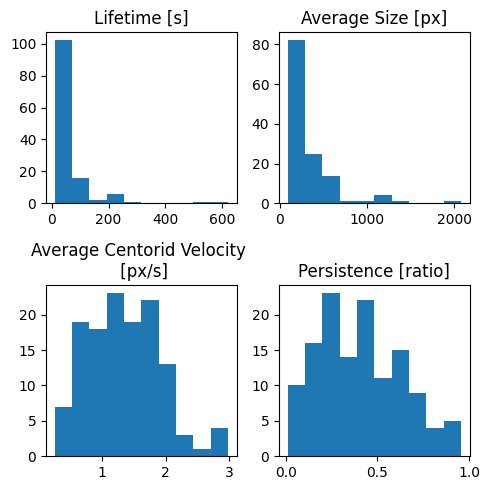

In [43]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(5, 5), sharex=False)

axs = axs.flatten()
axs[0].hist(summary_df["lifetime"], bins=10)
axs[0].set_title("Lifetime [s]")

axs[1].hist(summary_df["avg_size"], bins=10)
axs[1].set_title("Average Size [px]")

axs[2].hist(summary_df["avg_velocity"], bins=10)
axs[2].set_title("Average Centorid Velocity \n [px/s]")

axs[3].hist(summary_df["persistence"], bins=10)
axs[3].set_title("Persistence [ratio]")

plt.tight_layout()
# plt.show()
plt.savefig("summary_stats_fibers.png")

In [44]:
summary_df.persistence.mean()

0.4032760811460794

In [45]:
# add origin and end points to to napari at their respective frames
viewer = napari.current_viewer()
viewer.add_points(
    summary_df[["origin_t", "origin_x", "origin_y"]].values,
    name="origin",
    face_color="red",
    symbol="cross",
    size=10,
    n_dimensional=True,
)
viewer.add_points(
    summary_df[["end_t", "end_x", "end_y"]].values,
    name="end",
    face_color="blue",
    symbol="cross",
    size=10,
    n_dimensional=True,
)

<Points layer 'end' at 0x7f8720a4d4f0>

In [46]:
import matplotlib.pyplot as plt

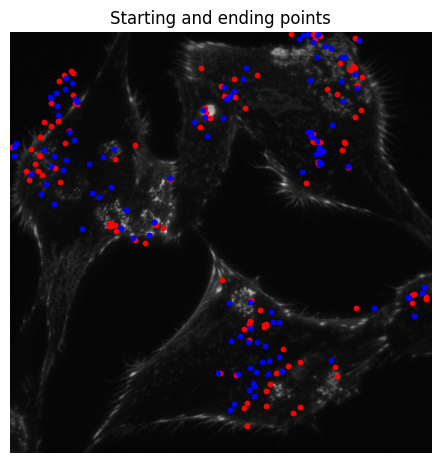

In [47]:
import napari
viewer = napari.Viewer()
viewer.add_image(stable_fibres[50:-50, ...,0 ], name="binned_actin")

# add origin and end points to to napari at their respective frames
viewer = napari.current_viewer()
viewer.add_points(
    summary_df[["origin_t", "origin_x", "origin_y"]].values,
    name="origin",
    face_color="red",
    symbol="cross",
    size=10,
    n_dimensional=True,
)
viewer.add_points(
    summary_df[["end_t", "end_x", "end_y"]].values,
    name="end",
    face_color="blue",
    symbol="cross",
    size=10,
    n_dimensional=True,
)

image_data = viewer.layers['binned_actin'].data

#slice_index = image_data.shape[0] // 2
selected_slice = image_data[0, :, :]

start_points = viewer.layers['origin'].data
filtered_starting_points = start_points[12:]
end_points = viewer.layers['end'].data
filtered_ending_points = end_points[12:]


x_points_start = [point[2] for point in filtered_starting_points]
y_points_start = [point[1] for point in filtered_starting_points]

x_points_end = [point[2] for point in filtered_ending_points]
y_points_end = [point[1] for point in filtered_ending_points]

plt.scatter(x_points_start, y_points_start, c='red', s=10) 
plt.scatter(x_points_end, y_points_end, c='blue', s=10)
plt.imshow(selected_slice, cmap='gray')  
#plt.legend(['Starting points', 'Ending points'], loc='upper right')
plt.tight_layout()
plt.title(f'Starting and ending points')
plt.axis('off')  
plt.savefig('starting_and_ending_points.png')
plt.show()


In [48]:
filtered_df_id_1 = df_all[df_all['id'] == 1]
filtered_df_id_1

,id,area,x,y,intensity_mean,frame
0,1,3321.0,68.065041,416.211382,230.627823,0
0,1,3528.0,67.298469,416.033163,228.714002,1
0,1,3618.0,66.223881,416.701493,220.559978,2
0,1,3708.0,65.987864,416.995146,218.008091,3
0,1,3519.0,66.608696,416.726343,227.197783,4
...,...,...,...,...,...,...
0,1,2574.0,87.370629,417.947552,173.804196,616
0,1,2655.0,87.603390,418.152542,177.494915,617
0,1,2790.0,88.067742,418.358065,183.817204,618
0,1,2907.0,88.408669,418.910217,188.540420,619


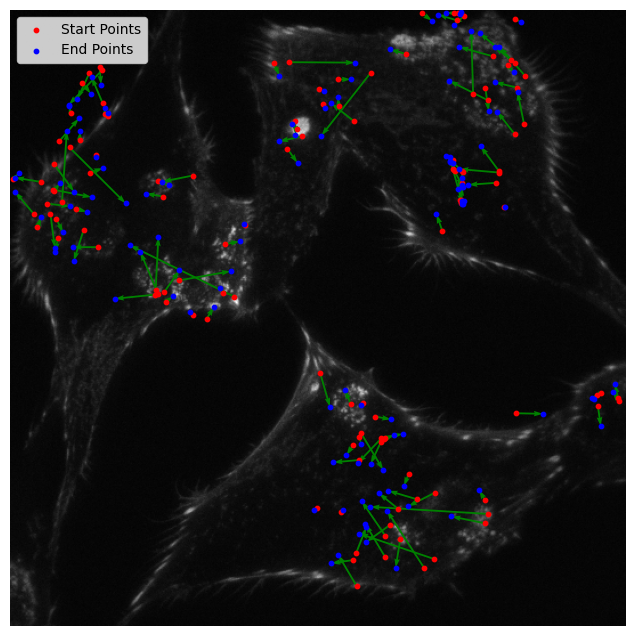

In [49]:
import napari
import pandas as pd
viewer = napari.Viewer()
viewer.add_image(stable_fibres[50:-50, ...,0 ], name="binned_actin")

# add origin and end points to to napari at their respective frames
viewer = napari.current_viewer()
viewer.add_points(
    summary_df[["origin_t", "origin_x", "origin_y"]].values,
    name="origin",
    face_color="red",
    symbol="cross",
    size=10,
    n_dimensional=True,
)
viewer.add_points(
    summary_df[["end_t", "end_x", "end_y"]].values,
    name="end",
    face_color="blue",
    symbol="cross",
    size=10,
    n_dimensional=True,
)

image_data = viewer.layers['binned_actin'].data

#slice_index = image_data.shape[0] // 2
selected_slice = image_data[0, :, :]

start_points = viewer.layers['origin'].data
#start_points = start_points[12:]
# change the column names to match the summary_df
start_points = pd.DataFrame(start_points, columns=['origin_t', 'origin_x', 'origin_y'])
merged_df_start = pd.merge(start_points, summary_df[['id', 'origin_x', 'origin_y']], on=['origin_x', 'origin_y'], how='left')

end_points = viewer.layers['end'].data
end_points = pd.DataFrame(end_points, columns=['end_t', 'end_x', 'end_y'])
merged_df_end = pd.merge(end_points, summary_df[['id', 'end_x', 'end_y']], on=['end_x', 'end_y'], how='left')

# Merge the DataFrames on 'id'
merged_df_full = pd.merge(merged_df_start, merged_df_end, on='id', suffixes=('_start', '_end'))

# Calculate differences (dx, dy) for arrow directions
merged_df_full['dx'] = merged_df_full['end_x'] - merged_df_full['origin_x']
merged_df_full['dy'] = merged_df_full['end_y'] - merged_df_full['origin_y']

# Plotting
plt.figure(figsize=(8, 8))
plt.quiver(merged_df_full['origin_y'], merged_df_full['origin_x'], merged_df_full['dy'], merged_df_full['dx'], angles='xy', scale_units='xy', scale=1, color='green', width=0.003)

# Optionally add start and end points
plt.scatter(merged_df_full['origin_y'], merged_df_full['origin_x'], color='red', label='Start Points', s=10)
plt.scatter(merged_df_full['end_y'], merged_df_full['end_x'], color='blue', label='End Points', s=10)
plt.imshow(selected_slice, cmap='gray')  

plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend()
plt.axis('off')
#plt.savefig('arrows_start_end.png',  dpi=300)
plt.show()



# Extract Values from the Distance Transformation Map

In [50]:
import pandas as pd
import numpy as np

def extract_value(x, y, dist_transform_upscaled, slice_index=0):
    # Convert coordinates to integers
    x = int(x)
    y = int(y)

    # Extract value from the distance map
    return dist_transform_upscaled[slice_index, x, y]

# Apply the function to each row for origin and end points
merged_df_full['origin_dist_value'] = merged_df_full.apply(lambda row: extract_value(row['origin_x'], row['origin_y'], dist_transform_upscaled), axis=1)
merged_df_full['end_dist_value'] = merged_df_full.apply(lambda row: extract_value(row['end_x'], row['end_y'], dist_transform_upscaled), axis=1)

mean_origin_dist_value = np.mean(merged_df_full["origin_dist_value"])
mean_end_dist_value = np.mean(merged_df_full["end_dist_value"])

print(f"Mean origin distance value: {mean_origin_dist_value}")
print(f"Mean end distance value: {mean_end_dist_value}")

#print(dist_transform_upscaled[0, 68, 416])


Mean origin distance value: 10.325581395348838
Mean end distance value: 11.930232558139535


# check if data is normally distributed

In [51]:
import numpy as np
import scipy.stats as stats

# Perform the Shapiro-Wilk test
#shapiro_test = stats.shapiro(merged_df_full['origin_dist_value'])
shapiro_test = stats.shapiro(merged_df_full['end_dist_value'])


print("Shapiro-Wilk Test statistic:", shapiro_test.statistic)
print("Shapiro-Wilk Test p-value:", shapiro_test.pvalue)

if shapiro_test.pvalue > 0.05:
    print("Data appears to be normally distributed")
else:
    print("Data does not appear to be normally distributed")


Shapiro-Wilk Test statistic: 0.9165761470794678
Shapiro-Wilk Test p-value: 7.092172609191039e-07
Data does not appear to be normally distributed


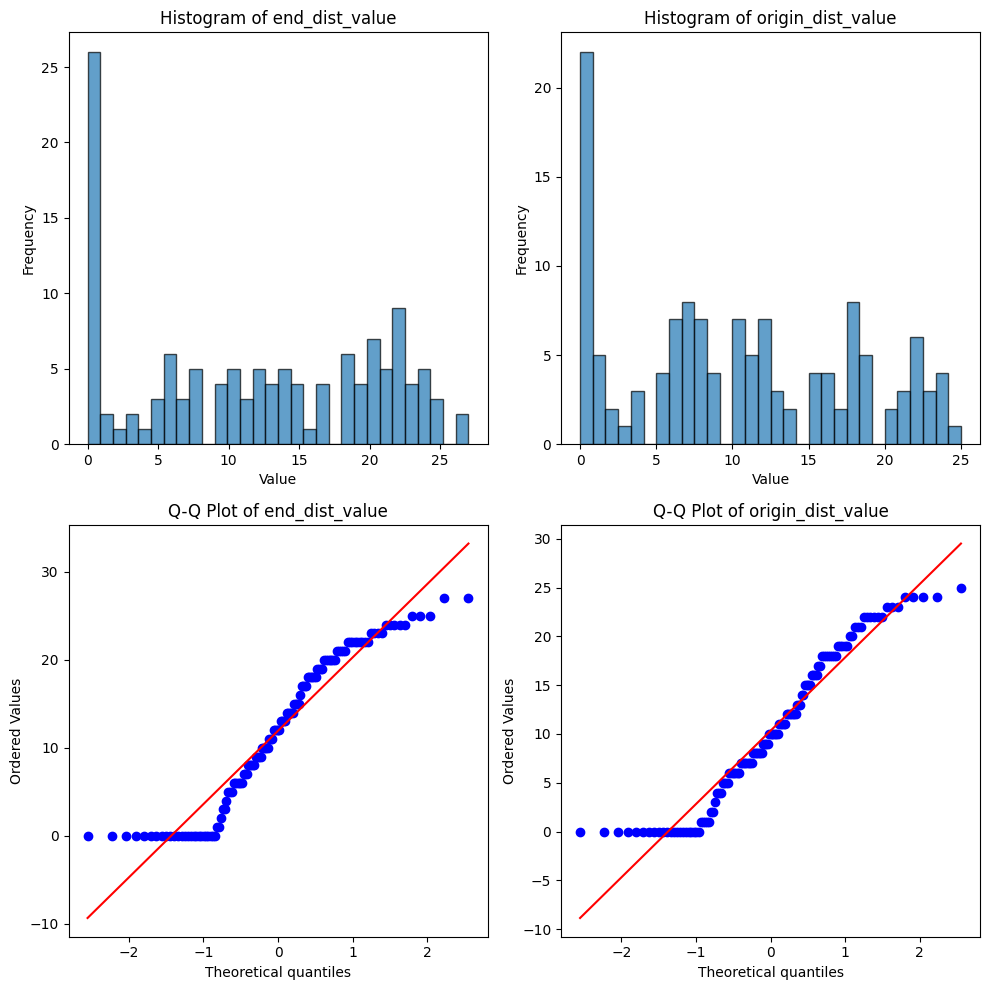

In [52]:
import matplotlib.pyplot as plt
import scipy.stats as stats

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0, 0].hist(merged_df_full['end_dist_value'], bins=30, edgecolor='black', alpha=0.7)
axs[0, 0].set_title('Histogram of end_dist_value')
axs[0, 0].set_xlabel('Value')
axs[0, 0].set_ylabel('Frequency')

axs[0, 1].hist(merged_df_full['origin_dist_value'], bins=30, edgecolor='black', alpha=0.7)
axs[0, 1].set_title('Histogram of origin_dist_value')
axs[0, 1].set_xlabel('Value')
axs[0, 1].set_ylabel('Frequency')

stats.probplot(merged_df_full['end_dist_value'], dist="norm", plot=axs[1, 0])
axs[1, 0].set_title('Q-Q Plot of end_dist_value')

stats.probplot(merged_df_full['origin_dist_value'], dist="norm", plot=axs[1, 1])
axs[1, 1].set_title('Q-Q Plot of origin_dist_value')

plt.tight_layout()
plt.show()


# Make log transformation

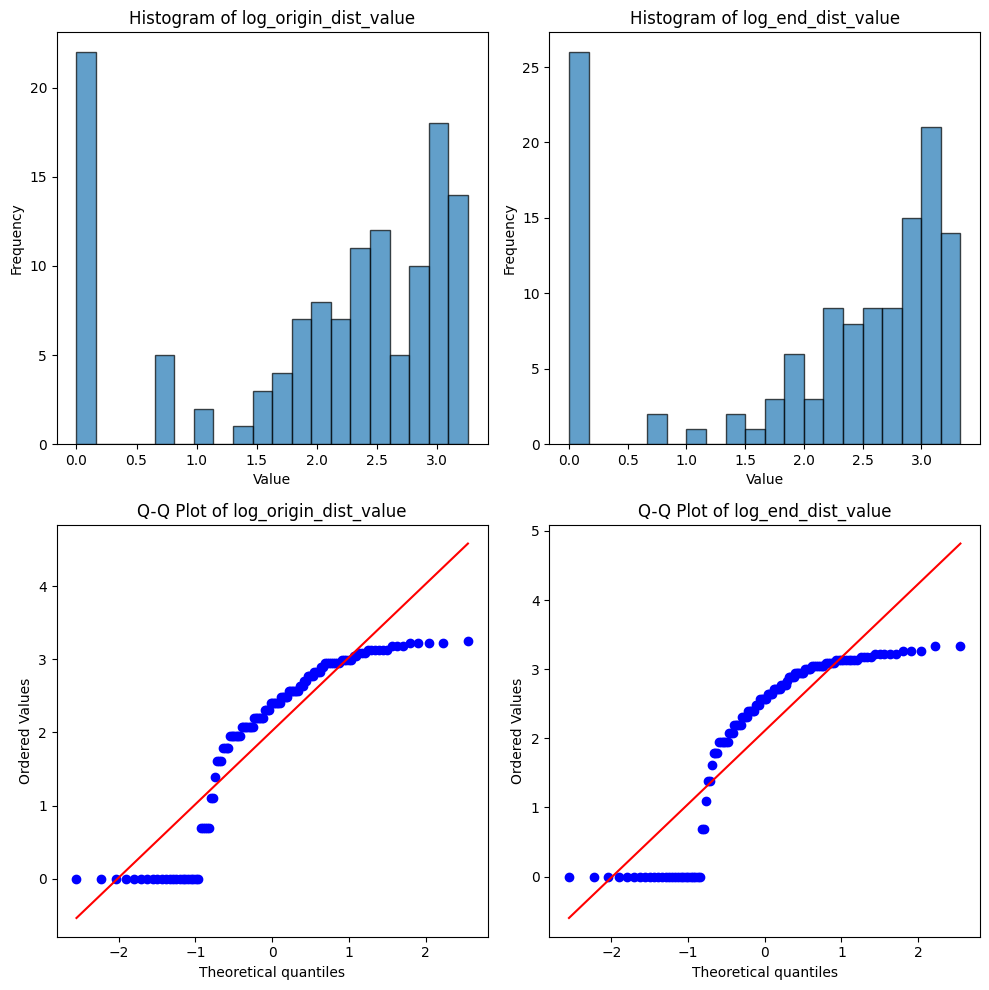

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

merged_df_full['origin_dist_value'] += 1
merged_df_full['end_dist_value'] += 1

# Perform log transformation
merged_df_full['log_origin_dist_value'] = np.log(merged_df_full['origin_dist_value'])
merged_df_full['log_end_dist_value'] = np.log(merged_df_full['end_dist_value'])

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0, 0].hist(merged_df_full['log_origin_dist_value'], bins=20, edgecolor='black', alpha=0.7)
axs[0, 0].set_title('Histogram of log_origin_dist_value')
axs[0, 0].set_xlabel('Value')
axs[0, 0].set_ylabel('Frequency')

axs[0, 1].hist(merged_df_full['log_end_dist_value'], bins=20, edgecolor='black', alpha=0.7)
axs[0, 1].set_title('Histogram of log_end_dist_value')
axs[0, 1].set_xlabel('Value')
axs[0, 1].set_ylabel('Frequency')

stats.probplot(merged_df_full['log_origin_dist_value'], dist="norm", plot=axs[1, 0])
axs[1, 0].set_title('Q-Q Plot of log_origin_dist_value')

stats.probplot(merged_df_full['log_end_dist_value'], dist="norm", plot=axs[1, 1])
axs[1, 1].set_title('Q-Q Plot of log_end_dist_value')

plt.tight_layout()
plt.show()



count    129.000000
mean      -1.604651
std        5.321564
min      -22.000000
25%       -3.000000
50%        0.000000
75%        1.000000
max       17.000000
Name: delta_start_end, dtype: float64


<Axes: ylabel='Density'>

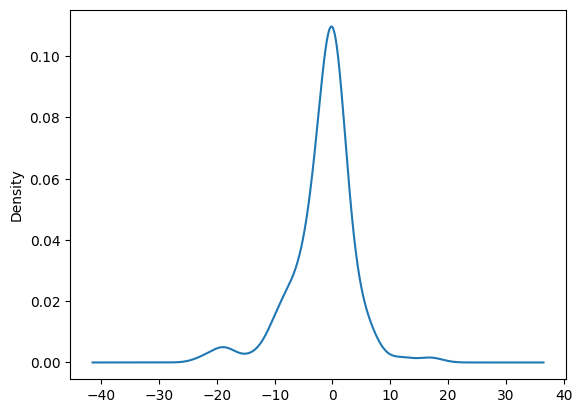

In [54]:
import seaborn

merged_df_full["delta_start_end"] = merged_df_full["origin_dist_value"] - merged_df_full["end_dist_value"]

print(merged_df_full["delta_start_end"].describe())

# plot density plot
merged_df_full["delta_start_end"].plot(kind="density")


# make statistical test

# Wilcoxon Signed-Rank Test

In [55]:
from scipy.stats import wilcoxon

# If data is normally distributed, use paired t-test
# t_statistic, p_value = ttest_rel(merged_df_full['origin_dist_value'], merged_df_full['end_dist_value'])
# print("Paired t-test results: t-statistic =", t_statistic, ", p-value =", p_value)

# since data is not normally distributed, use Wilcoxon signed-rank test
# w_statistic, p_value = wilcoxon(merged_df_full['origin_dist_value'], merged_df_full['end_dist_value'])
start_end_differences = merged_df_full['delta_start_end'].to_numpy()
wilcoxon_test = wilcoxon(start_end_differences)
w_statistic, p_value = wilcoxon_test
#print(len(start_end_differences))
print("Wilcoxon statistic =", w_statistic, ", p-value =", p_value)


Wilcoxon statistic = 1259.0 , p-value = 0.0005863222168842795


In [56]:
import numpy as np
from scipy.stats import norm

differences = merged_df_full['delta_start_end'].to_numpy()

non_zero_differences = np.array([d for d in differences if d != 0])
ranks = np.argsort(np.argsort(np.abs(non_zero_differences))) + 1

# Assign signs to ranks
signed_ranks = ranks * np.sign(non_zero_differences)

# Calculate sum of positive and negative ranks
W_pos = np.sum(signed_ranks[signed_ranks > 0])
W_neg = np.abs(np.sum(signed_ranks[signed_ranks < 0]))

# Test statistic is the smaller of W_pos and W_neg
W = min(W_pos, W_neg)

# For large samples, approximate the p-value using a normal distribution
n = len(non_zero_differences)
mean_W = n * (n + 1) / 4
std_W = np.sqrt(n * (n + 1) * (2 * n + 1) / 24)
z = (W - mean_W) / std_W
p_value = 2 * norm.cdf(z)

print("Wilcoxon Signed-Rank Test statistic:", W)
print("P-value:", p_value)


Wilcoxon Signed-Rank Test statistic: 1241
P-value: 0.00047101809590011627


# Correlation of starting Distance to border and magnitude of differences

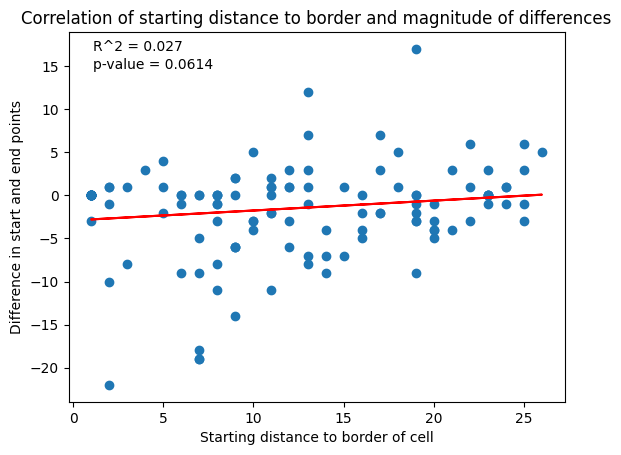

In [57]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

# Assuming merged_df_full['origin_dist_value'] and merged_df_full['delta_start_end'] are defined
x = merged_df_full['origin_dist_value']
y = merged_df_full['delta_start_end']

# Perform linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

# Calculate R^2 value
r_squared = r_value**2

# Scatter plot
plt.scatter(x, y)
plt.xlabel('Starting distance to border of cell')
plt.ylabel('Difference in start and end points')
plt.title("Correlation of starting distance to border and magnitude of differences")

# Plot the regression line
regression_line = slope * x + intercept
plt.plot(x, regression_line, color='red')  # You can change the color if needed

# Annotate the plot with R^2 and p-value
plt.annotate(f'R^2 = {r_squared:.3f}', xy=(0.05, 0.95), xycoords='axes fraction')
plt.annotate(f'p-value = {p_value:.3g}', xy=(0.05, 0.90), xycoords='axes fraction')

plt.show()




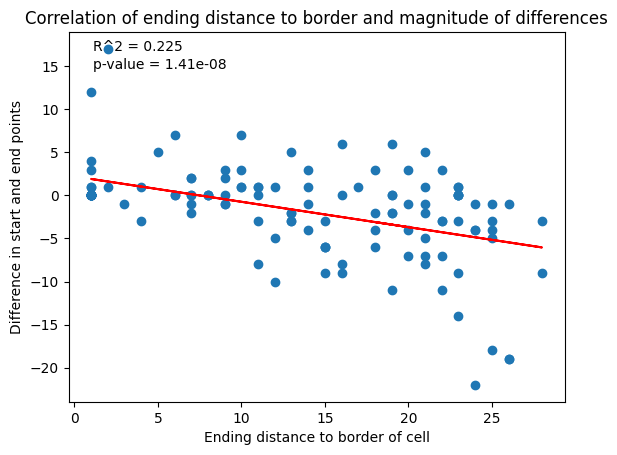

In [58]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

x = merged_df_full['end_dist_value']
y = merged_df_full['delta_start_end']

# Perform linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

# Calculate R^2 value
r_squared = r_value**2

# Scatter plot
plt.scatter(x, y)
plt.xlabel('Ending distance to border of cell')
plt.ylabel('Difference in start and end points')
plt.title("Correlation of ending distance to border and magnitude of differences")

# Plot the regression line
regression_line = slope * x + intercept
plt.plot(x, regression_line, color='red')  # You can change the color if needed

# Annotate the plot with R^2 and p-value
plt.annotate(f'R^2 = {r_squared:.3f}', xy=(0.05, 0.95), xycoords='axes fraction')
plt.annotate(f'p-value = {p_value:.3g}', xy=(0.05, 0.90), xycoords='axes fraction')

plt.show()

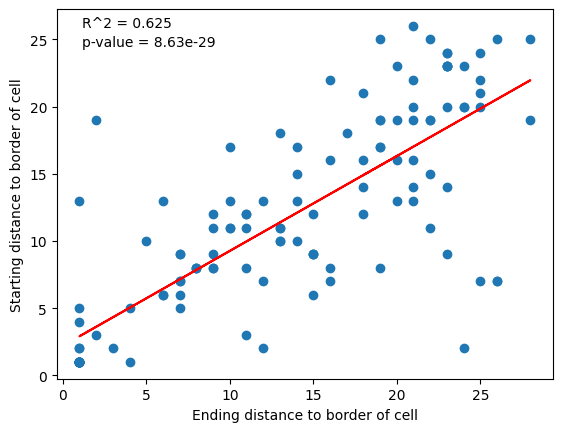

In [59]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

x = merged_df_full['end_dist_value']
y = merged_df_full['origin_dist_value']

# Perform linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

# Calculate R^2 value
r_squared = r_value**2

# Scatter plot
plt.scatter(x, y)
plt.xlabel('Ending distance to border of cell')
plt.ylabel('Starting distance to border of cell')
plt.title("")

# Plot the regression line
regression_line = slope * x + intercept
plt.plot(x, regression_line, color='red')  # You can change the color if needed

# Annotate the plot with R^2 and p-value
plt.annotate(f'R^2 = {r_squared:.3f}', xy=(0.05, 0.95), xycoords='axes fraction')
plt.annotate(f'p-value = {p_value:.3g}', xy=(0.05, 0.90), xycoords='axes fraction')

plt.show()

# Sign Test

In [60]:
import statsmodels
from scipy.stats import binom

start_end_differences = merged_df_full['delta_start_end'].to_numpy()

# Remove zeros and count positive and negative differences
non_zero_differences = [d for d in start_end_differences if d != 0]
num_positive = sum(1 for d in non_zero_differences if d > 0)
num_negative = len(non_zero_differences) - num_positive

# Calculate the test statistic (the smaller of num_positive and num_negative)
test_statistic = min(num_positive, num_negative)

# Total number of non-zero observations
n = len(non_zero_differences)

# Calculate the p-value (two-tailed test)
p_value = 2 * binom.cdf(test_statistic, n, 0.5)

print("Sign test statistic:", test_statistic)
print("P-value:", p_value)



Sign test statistic: 34
P-value: 0.01602027478889998


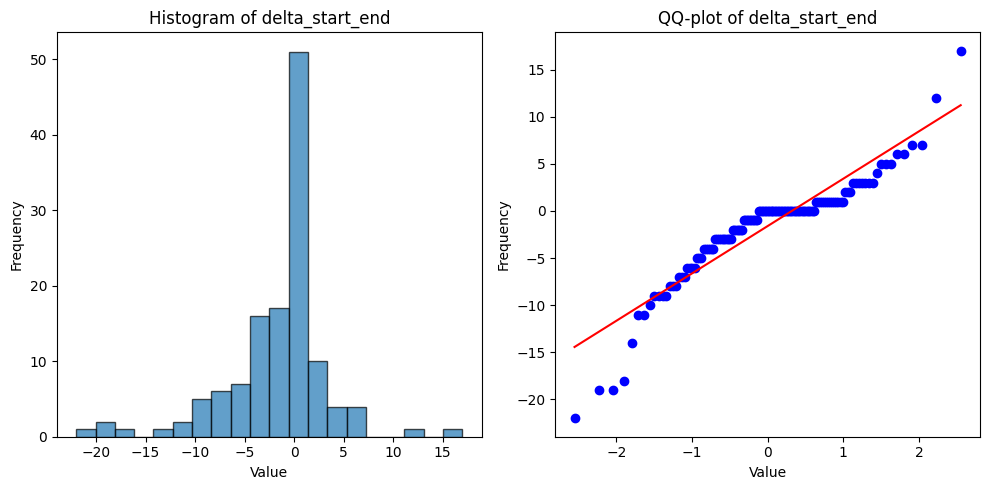

In [61]:
import matplotlib.pyplot as plt

# Create a figure with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Adjusted figsize for better aspect ratio

# Plot on the first subplot
axs[0].hist(merged_df_full['delta_start_end'], bins=20, edgecolor='black', alpha=0.7)
axs[0].set_title('Histogram of delta_start_end')
axs[0].set_xlabel('Value')
axs[0].set_ylabel('Frequency')

# Plot on the second subplot
stats.probplot(merged_df_full['delta_start_end'], dist="norm", plot=axs[1])
axs[1].set_title('QQ-plot of delta_start_end')
axs[1].set_xlabel('Value')
axs[1].set_ylabel('Frequency')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


# Labeling of individual IDs

## Create boolean mask for ID = 1

In [62]:
import napari

segmented_data = events_upscaled

specific_id = 1

# Create boolean mask
boolean_mask = segmented_data == specific_id

total_nbr_of_IDs = np.max(segmented_data)
print(f"total number of IDs: {total_nbr_of_IDs}")

# convert to int 
# int_mask = boolean_mask.astype(int)

viewer.add_labels(boolean_mask, name='boolean_mask_layer')


total number of IDs: 267


<Labels layer 'boolean_mask_layer' at 0x7f8722e7fca0>

## label boolean mask from ID = 1 into individual segments

In [63]:
# start the viewer
viewer = napari.Viewer()
viewer.add_image(stable_fibres[50:-50, ...,0 ], name="binned_actin")
viewer.add_labels(events_upscaled, name="events_1")

<Labels layer 'events_1' at 0x7f86a2e56c40>

In [64]:
from scipy.ndimage import label

# 'labeled_results' will be a list of tuples, where each tuple contains (labeled_array, num_features) for each time step
labeled_results = [label(frame) for frame in boolean_mask]
labeled_arrays = [result[0] for result in labeled_results]
num_features = [result[1] for result in labeled_results]

# Stack the labeled arrays along a dimension
stacked_array_id_1 = np.stack(labeled_arrays, axis=0)
# 'stacked_array' is now a 3D numpy array where each 'slice' along the third dimension is a labeled time step
print(max(num_features))   
#labeled_array, num_features = stacked_array

#print('Number of features:', num_features)
viewer.add_labels(stacked_array_id_1, name='labelled_mask_layer_ID_1')

9


<Labels layer 'labelled_mask_layer_ID_1' at 0x7f86aababd90>

# Create regionprops table for individual ID segments (here ID = 1)

In [65]:
from skimage.measure import regionprops_table

df_all_id_1 = []
for idx, e in enumerate(stacked_array_id_1):
    props = regionprops_table(e, properties=("label", "area", "centroid", 'intensity_mean'), intensity_image=actin[idx][:, :1160])
    df_temp = pd.DataFrame(props)
    df_temp["frame"] = idx
    df_all_id_1.append(df_temp)

df_all_id_1 = pd.concat(df_all_id_1)

df_all_id_1.rename(columns={"centroid-0": "x", "centroid-1": "y", "label": "id"}, inplace=True)
df_all_id_1

,id,area,x,y,intensity_mean,frame
0,1,2313.0,56.470817,415.385214,227.238651,0
1,2,1008.0,94.669643,418.107143,238.404762,0
0,1,2475.0,55.501818,415.370909,227.797980,1
1,2,1053.0,95.025641,417.589744,230.867047,1
0,1,2556.0,54.250000,416.278169,220.761737,2
...,...,...,...,...,...,...
0,1,2574.0,87.370629,417.947552,173.804196,616
0,1,2655.0,87.603390,418.152542,177.494915,617
0,1,2790.0,88.067742,418.358065,183.817204,618
0,1,2907.0,88.408669,418.910217,188.540420,619


In [66]:
from trackpy import link_df

trackpy_df_id_1 = pd.DataFrame(df_all_id_1[['x', 'y', 'frame']])

linked_df_id_1 = link_df(trackpy_df_id_1, search_range=10)
linked_df_id_1


Frame 620: 1 trajectories present.


,x,y,frame,particle
0,56.470817,415.385214,0,0
1,94.669643,418.107143,0,1
0,55.501818,415.370909,1,0
1,95.025641,417.589744,1,1
0,54.250000,416.278169,2,0
...,...,...,...,...
0,87.370629,417.947552,616,205
0,87.603390,418.152542,617,205
0,88.067742,418.358065,618,205
0,88.408669,418.910217,619,205


# Add tracks of "particles" to napari

In [67]:
reordered_columns = linked_df_id_1[["particle", "frame", "x", "y"]]

reordered_columns_sorted_id_1 = reordered_columns.sort_values(by=["particle"], ascending=True)

viewer.add_tracks(reordered_columns_sorted_id_1, name="tracks")

<Tracks layer 'tracks' at 0x7f885ffd1130>

# Velocity calculation

In [68]:
import pandas as pd
import numpy as np

linked_df_id_1.sort_values(by=['particle', 'frame'], inplace=True)

# Calculate displacement in x and y for each particle
linked_df_id_1['dx'] = linked_df_id_1.groupby('particle')['x'].diff().fillna(0)
linked_df_id_1['dy'] = linked_df_id_1.groupby('particle')['y'].diff().fillna(0)

linked_df_id_1['velocity'] = np.sqrt(linked_df_id_1['dx']**2 + linked_df_id_1['dy']**2)

average_velocity = linked_df_id_1.groupby('particle')['velocity'].mean()

print(average_velocity)

linked_df_id_1


particle
0      0.612551
1      0.777068
2      1.296480
3      3.011635
4      0.613366
         ...   
203    0.656865
204    0.000000
205    0.548645
206    0.774309
207    0.824663
Name: velocity, Length: 208, dtype: float64


,x,y,frame,particle,dx,dy,velocity
0,56.470817,415.385214,0,0,0.000000,0.000000,0.000000
0,55.501818,415.370909,1,0,-0.968999,-0.014305,0.969105
0,54.250000,416.278169,2,0,-1.251818,0.907260,1.546017
0,53.767123,416.582192,3,0,-0.482877,0.304023,0.570613
0,53.693727,416.162362,4,0,-0.073396,-0.419830,0.426198
...,...,...,...,...,...,...,...
1,130.000000,388.000000,602,206,-0.375000,0.750000,0.838525
1,127.000000,387.666667,606,207,0.000000,0.000000,0.000000
1,128.500000,386.500000,607,207,1.500000,-1.166667,1.900292
1,128.714286,385.857143,608,207,0.214286,-0.642857,0.677631


Text(0, 0.5, 'Velocity Magnitude')

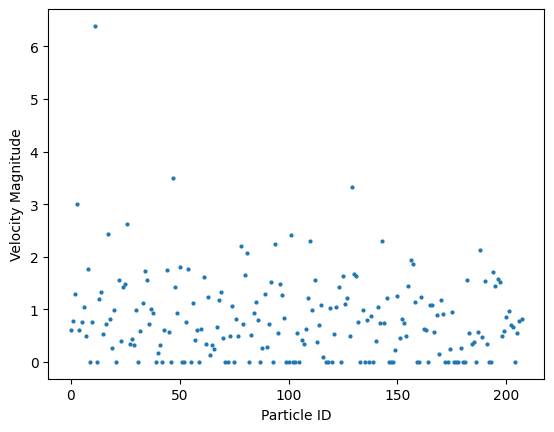

In [69]:
data = np.array(average_velocity)

plt.plot(data, linestyle='None', marker = "o", ms=2)
plt.xlabel("Particle ID")
plt.ylabel("Velocity Magnitude")

# Velocity Calculation for all IDs in segmented_data

## Create boolean masks for all IDs

In [70]:
import numpy as np
from scipy.ndimage import label
import napari

segmented_data = events_upscaled
total_nbr_of_IDs = np.max(segmented_data)
print(f"Total number of IDs: {total_nbr_of_IDs}")

# Dictionary to store boolean masks for each ID
boolean_masks = {}

for specific_id in range(1, total_nbr_of_IDs):
    # Create and store boolean mask for each ID
    boolean_masks[specific_id] = segmented_data == specific_id




Total number of IDs: 267


## Labelling of all IDs into segments

In [71]:
# start the viewer
viewer = napari.Viewer()
viewer.add_image(stable_fibres[50:-50, ...,0 ], name="binned_actin")
viewer.add_labels(events_upscaled, name="events_1")

<Labels layer 'events_1' at 0x7f8789feb880>

### Split it up: 1. First 40 IDs

In [72]:
batch_size = 40  # Number of IDs to process in each batch

# Define the start and end ID for the current batch
# For the first run, set start_id = 1 and end_id = 40
# For subsequent runs, adjust these values accordingly (e.g., 41-80, 81-120, etc.)
start_id = 1
end_id = start_id + batch_size - 1

#viewer = napari.Viewer()

# Dictionary to store the stacked arrays
stacked_arrays = {}

for specific_id in range(start_id, min(end_id + 1, total_nbr_of_IDs + 1)):
    boolean_mask = boolean_masks[specific_id]

    # Apply the label function to each frame in the boolean mask
    labeled_results = [label(frame) for frame in boolean_mask]
    labeled_arrays = [result[0] for result in labeled_results]
    num_features = [result[1] for result in labeled_results]

    # Stack the labeled arrays along a dimension
    stacked_array = np.stack(labeled_arrays, axis=0)
    
    # Store the stacked array in the dictionary
    stacked_arrays[specific_id] = stacked_array

    # Add the stacked array as a labeled layer to the viewer
    # viewer.add_labels(stacked_array, name=f'labelled_mask_layer_ID_{specific_id}')

    print(f"Max number of features for ID {specific_id}: {max(num_features)}")


Max number of features for ID 1: 9
Max number of features for ID 2: 2
Max number of features for ID 3: 1
Max number of features for ID 4: 1
Max number of features for ID 5: 5
Max number of features for ID 6: 2
Max number of features for ID 7: 1
Max number of features for ID 8: 1
Max number of features for ID 9: 4
Max number of features for ID 10: 2
Max number of features for ID 11: 0
Max number of features for ID 12: 4
Max number of features for ID 13: 3
Max number of features for ID 14: 0
Max number of features for ID 15: 0
Max number of features for ID 16: 0
Max number of features for ID 17: 0
Max number of features for ID 18: 0
Max number of features for ID 19: 0
Max number of features for ID 20: 2
Max number of features for ID 21: 1
Max number of features for ID 22: 2
Max number of features for ID 23: 0
Max number of features for ID 24: 2
Max number of features for ID 25: 0
Max number of features for ID 26: 2
Max number of features for ID 27: 1
Max number of features for ID 28: 0
M

### Make regionprops table for all IDs in the first batch

In [73]:
from skimage.measure import regionprops_table
import pandas as pd

# Assuming 'stacked_arrays' is a dictionary containing stacked arrays for each ID
# If not already created, you would need to create it similar to the boolean_masks dictionary
# but storing the stacked arrays instead.

df_all_ids = {}  # Dictionary to store DataFrames for each ID

for specific_id, stacked_array in stacked_arrays.items():
    df_temp_list = []
    
    for idx, e in enumerate(stacked_array):
        props = regionprops_table(e, properties=("label", "area", "centroid", 'intensity_mean'), 
                                  intensity_image=actin[idx][:, :1160])
        df_temp = pd.DataFrame(props)
        df_temp["frame"] = idx
        df_temp_list.append(df_temp)

    # Concatenate all DataFrames for this specific ID
    df_all_ids[specific_id] = pd.concat(df_temp_list)

    # Rename columns for clarity
    df_all_ids[specific_id].rename(columns={"centroid-0": "x", "centroid-1": "y", "label": "id"}, inplace=True)
    print(f"Finished ID {specific_id}")

print("done")

Finished ID 1
Finished ID 2
Finished ID 3
Finished ID 4
Finished ID 5
Finished ID 6
Finished ID 7
Finished ID 8
Finished ID 9
Finished ID 10
Finished ID 11
Finished ID 12
Finished ID 13
Finished ID 14
Finished ID 15
Finished ID 16
Finished ID 17
Finished ID 18
Finished ID 19
Finished ID 20
Finished ID 21
Finished ID 22
Finished ID 23
Finished ID 24
Finished ID 25
Finished ID 26
Finished ID 27
Finished ID 28
Finished ID 29
Finished ID 30
Finished ID 31
Finished ID 32
Finished ID 33
Finished ID 34
Finished ID 35
Finished ID 36
Finished ID 37
Finished ID 38
Finished ID 39
Finished ID 40
done


### Linking of all IDs in the first batch

In [77]:
# Dictionary to store linked DataFrames for each ID
linked_dfs = {}

for specific_id in range(start_id, min(end_id + 1, total_nbr_of_IDs + 1)):
    
    if df_all_ids[specific_id].empty:
        print(f"DataFrame for ID {specific_id} is empty.")
        continue  # Skip this ID and continue with the next one
    
    # Extract relevant columns for the specific ID
    trackpy_df = pd.DataFrame(df_all_ids[specific_id][['x', 'y', 'frame']])

    # Apply the link_df function
    linked_df = link_df(trackpy_df, search_range=10)

    # Store the linked DataFrame in the dictionary
    linked_dfs[specific_id] = linked_df
    print(f"Finished ID {specific_id}")
    
print("done")


Frame 207: 1 trajectories present.
Finished ID 40


KeyboardInterrupt: 

### IDs 41-100

In [75]:
# batch_size = 60  # Number of IDs to process in each batch
# 
# # Define the start and end ID for the current batch
# # For the first run, set start_id = 1 and end_id = 40
# # For subsequent runs, adjust these values accordingly (e.g., 41-80, 81-120, etc.)
# start_id = 40
# end_id = start_id + batch_size - 1
# 
# viewer = napari.Viewer()
# 
# for specific_id in range(start_id, min(end_id + 1, total_nbr_of_IDs + 1)):
#     boolean_mask = boolean_masks[specific_id]
# 
#     # Apply the label function to each frame in the boolean mask
#     labeled_results = [label(frame) for frame in boolean_mask]
#     labeled_arrays = [result[0] for result in labeled_results]
#     num_features = [result[1] for result in labeled_results]
# 
#     # Stack the labeled arrays along a dimension
#     stacked_array = np.stack(labeled_arrays, axis=0)
# 
#     # Add the stacked array as a labeled layer to the viewer
#     viewer.add_labels(stacked_array, name=f'labelled_mask_layer_ID_{specific_id}')
# 
#     print(f"Max number of features for ID {specific_id}: {max(num_features)}")


In [76]:
import warnings


class CameraSetter:
    """A context manager to adjust viewer camera settings before rendering."""

    def __init__(self, viewer):
        self.viewer = viewer
        # get initial settings
        self.center = viewer.camera.center
        self.zoom = viewer.camera.zoom
        self.angles = viewer.camera.angles

        self.input_canvas_size = viewer.window.qt_viewer.canvas.size

        extent = viewer._sliced_extent_world[:, -2:]
        scene_size = (extent[1] - extent[0]) / viewer.window.qt_viewer.canvas.pixel_scale  # adjust for pixel scaling
        grid_size = list(viewer.grid.actual_shape(len(viewer.layers)))

        # Adjust grid_size if necessary
        if len(scene_size) > len(grid_size):
            grid_size = [1] * (len(scene_size) - len(grid_size)) + grid_size

        # calculate target size i.e the size the canvas should be to fit the whole scene
        self.target_size = tuple((scene_size[::-1] / 2 * grid_size[::-1]).astype(int))
        self.center = viewer.camera.center
        self.zoom = viewer.camera.zoom
        self.angles = viewer.camera.angles

    # copied from viewer.reset_view and modified without padding
    def _center_on_canvas(self):
        """Reset the camera view."""
        extent = self.viewer._sliced_extent_world
        scene_size = extent[1] - extent[0]
        corner = extent[0]
        grid_size = list(self.viewer.grid.actual_shape(len(self.viewer.layers)))
        if len(scene_size) > len(grid_size):
            grid_size = [1] * (len(scene_size) - len(grid_size)) + grid_size
        size = np.multiply(scene_size, grid_size)
        center = np.add(corner, np.divide(size, 2))[-self.viewer.dims.ndisplay :]
        center = [0] * (self.viewer.dims.ndisplay - len(center)) + list(center)
        self.viewer.camera.center = center

        if np.max(size) == 0:
            self.viewer.camera.zoom = np.min(self.viewer._canvas_size)
        else:
            scale = np.array(size[-2:])
            scale[np.isclose(scale, 0)] = 1
            self.viewer.camera.zoom = 1 * np.min(np.array(self.viewer._canvas_size) / scale)
        self.viewer.camera.angles = (0, 0, 90)

    def __enter__(self):
        """Set up the viewer for rendering."""
        self.viewer.window.qt_viewer.canvas.size = self.target_size
        self._center_on_canvas()

    def __exit__(self, exc_type, exc_val, exc_tb):
        """Reset the viewer after rendering."""
        self.viewer.window.qt_viewer.canvas.size = self.input_canvas_size
        self.viewer.camera.center = self.center
        self.viewer.camera.zoom = self.zoom
        self.viewer.camera.angles = self.angles


def render_as_rgb(viewer, axis: None | int = None):
    """Render the viewer for a single timepoint."""
    with CameraSetter(viewer):
        if axis is not None:
            rgb = []
            for i in range(viewer.dims.range[axis][1].astype(int)):
                viewer.dims.set_current_step(axis, i)
                rendered_img = viewer.window.qt_viewer.canvas.render(alpha=False)
                rgb.append(rendered_img)
            rendered_img = np.stack(rgb)
        else:
            rendered_img = viewer.window.qt_viewer.canvas.render(alpha=False)
    return rendered_img


# Usage
rgb = []
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    rendered_img = render_as_rgb(viewer, 0)

TypeError: unsupported operand type(s) for |: 'NoneType' and 'type'

In [ ]:
import cv2

# Read the first image to get the width, height
frame = rendered_img[0]
h, w, layers = frame.shape

# Define the codec and create a VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
out = cv2.VideoWriter("tracked_waves_actin_2.mp4", fourcc, 60, (w, h))

for image in rendered_img:
    out.write(cv2.cvtColor(image, cv2.COLOR_RGBA2BGR))  # Write out frame to video

# Release everything when the job is finished
out.release()
cv2.destroyAllWindows()

In [ ]:
viewer = napari.Viewer()
viewer.add_image(actin, colormap="gray_r", name="actin")
viewer.add_image(myosin, colormap="gray_r", name="myosin")
viewer.add_image(rGBD, colormap="gray_r", name="rGBD")
viewer.add_labels(events_upscaled, name="events_filtered")

In [ ]:
io.imshow(rendered_img)

In [ ]:
from __future__ import annotations
import napari
import numpy as np
import warnings
from skimage import io
from magicgui import magicgui
from pathlib import Path
from typing import Optional

viewer = napari.Viewer()

class CameraSetter:
    """A context manager to adjust viewer camera settings before rendering."""

    def __init__(self, viewer, upsample_factor=1):
        self.viewer = viewer
        # get initial settings
        self.center = viewer.camera.center
        self.zoom = viewer.camera.zoom
        self.angles = viewer.camera.angles

        self.input_canvas_size = viewer.window.qt_viewer.canvas.size

        extent = viewer._sliced_extent_world[:, -2:]
        scene_size = (extent[1] - extent[0]) / viewer.window.qt_viewer.canvas.pixel_scale * upsample_factor # adjust for pixel scaling
        grid_size = list(viewer.grid.actual_shape(len(viewer.layers)))

        # Adjust grid_size if necessary
        if len(scene_size) > len(grid_size):
            grid_size = [1] * (len(scene_size) - len(grid_size)) + grid_size

        # calculate target size i.e the size the canvas should be to fit the whole scene
        self.target_size = tuple((scene_size[::-1] * grid_size[::-1]).astype(int))
        self.center = viewer.camera.center
        self.zoom = viewer.camera.zoom
        self.angles = viewer.camera.angles

    # copied from viewer.reset_view and modified without padding
    def _center_on_canvas(self):
        """Reset the camera view."""
        extent = self.viewer._sliced_extent_world
        scene_size = extent[1] - extent[0]
        corner = extent[0]
        grid_size = list(self.viewer.grid.actual_shape(len(self.viewer.layers)))
        if len(scene_size) > len(grid_size):
            grid_size = [1] * (len(scene_size) - len(grid_size)) + grid_size
        size = np.multiply(scene_size, grid_size)
        center = np.add(corner, np.divide(size, 2))[-self.viewer.dims.ndisplay :]
        center = [0] * (self.viewer.dims.ndisplay - len(center)) + list(center)
        self.viewer.camera.center = center

        if np.max(size) == 0:
            self.viewer.camera.zoom = np.min(self.viewer._canvas_size)
        else:
            scale = np.array(size[-2:])
            scale[np.isclose(scale, 0)] = 1
            self.viewer.camera.zoom = 1 * np.min(np.array(self.viewer._canvas_size) / scale)
        self.viewer.camera.angles = (0, 0, 90)

    def __enter__(self):
        """Set up the viewer for rendering."""
        self.viewer.window.qt_viewer.canvas.size = self.target_size
        self._center_on_canvas()

    def __exit__(self, exc_type, exc_val, exc_tb):
        """Reset the viewer after rendering."""
        self.viewer.window.qt_viewer.canvas.size = self.input_canvas_size
        self.viewer.camera.center = self.center
        self.viewer.camera.zoom = self.zoom
        self.viewer.camera.angles = self.angles

def get_choices(gui):
    """Return the choices for the axis dropdown."""
    viewer: napari.Viewer
    viewer = napari.current_viewer()
    choices = []
    for i, axis in enumerate(viewer.dims.axis_labels[:-2]):
        if axis is not None:
            choices.append(i)
    return choices

@magicgui(call_button="export", directory={"mode": "d", "label": "Choose a directory"}, axis={"choices": get_choices}, output_type={"choices": ["tif", "mp4"]})
def render_as_rgb(viewer: napari.Viewer, axis: Optional[int], directory=Path(), name: str = "out",  output_type = "mp4", fps: int = 12, upsample_factor: int = 1):
    """Render the viewer for a single timepoint."""
    axis = int(axis) if axis is not None else None
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        with CameraSetter(viewer, upsample_factor):
            if axis is not None:
                rgb = []
                for i in range(viewer.dims.range[axis][1].astype(int)):
                    viewer.dims.set_current_step(axis, i)
                    rendered_img = viewer.window.qt_viewer.canvas.render(alpha=False)
                    rgb.append(rendered_img)
                rendered_img = np.stack(rgb)
            else:
                rendered_img = viewer.window.qt_viewer.canvas.render(alpha=False)

    outpath = directory.joinpath(f"{name}.{output_type}").as_posix()
    if output_type == "tif":
        io.imsave(outpath, rendered_img)
    elif output_type == "mp4":
        if axis is None:
            raise ValueError("You must specify an axis to export as mp4")
        try:
            import cv2
        except ImportError:
            raise ImportError("You must install opencv to export as mp4, try `pip install opencv-python`")

        # Read the first image to get the width, height
        frame = rendered_img[0]
        h, w, layers = frame.shape

        # Define the codec and create a VideoWriter object
        fourcc = cv2.VideoWriter_fourcc(*"mp4v")
        out = cv2.VideoWriter(outpath, fourcc, fps, (w, h))

        for image in rendered_img:
            out.write(cv2.cvtColor(image, cv2.COLOR_RGBA2BGR))  # Write out frame to video

        # Release everything when the job is finished
        out.release()
        try:
            cv2.destroyAllWindows()
        except:
            print("could not close cv2 windows")


if globals().get("viewer") is None:
    viewer = napari.Viewer()
else:
    viewer = globals()["viewer"]

viewer.window.add_dock_widget(render_as_rgb, name="render as rgb")
viewer.show(block=True)